In [6]:
# General Packages
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import itertools
# import multiprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (8, 6)
import scikitplot as skplt

/var/folders/wn/2ch9rcy96cd00gw_gpt2r4k80000gn/T/ipykernel_24468/2739943092.py:13: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


ModuleNotFoundError: No module named 'scikitplot'

In [7]:
# Supervised Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn import feature_selection
import xgboost as xgb # XGBOOST
from xgboost.sklearn import XGBClassifier # XGBOOST
import hyperopt #CatBoost
from catboost import Pool, CatBoostClassifier #CatBoost
import lightgbm as lgb # Light GBM
import statsmodels.api as sm # Logistic Regression with StatModels

ModuleNotFoundError: No module named 'hyperopt'

In [8]:
# Unsupervised Models
from sklearn.decomposition import PCA

In [9]:
# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

In [10]:
# Grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

In [11]:
# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [12]:
# Esemble Voting
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

ModuleNotFoundError: No module named 'mlxtend'

In [13]:
# Stacking
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib.colors import ListedColormap

In [14]:
import time
import datetime
import platform
start = time.time()

In [15]:
print('Version      :', platform.python_version())
print('Compiler     :', platform.python_compiler())
print('Build        :', platform.python_build())

print("\nCurrent date and time using isoformat:")
print(datetime.datetime.now().isoformat())

Version      : 3.8.13
Compiler     : Clang 12.0.0 
Build        : ('default', 'Mar 28 2022 06:16:26')

Current date and time using isoformat:
2022-08-23T19:32:17.383969


In [16]:
# Write model submissions?
save = True
n_row = None
debug = False
if debug is True: n_row = 80

In [17]:
# Master Parameters:
n_splits = 2 # Cross Validation Splits
n_iter = 70 # Randomized Search Iterations
scoring = 'accuracy' # Model Selection during Cross-Validation
rstate = 27 # Random State used 
testset_size = 0.35

In [18]:
# Boosting rounds
num_rounds = 800

In [19]:
# Trees Parameters
n_tree_range = st.randint(100, num_rounds)

In [23]:
# Load
train_df = pd.read_csv("titanic_train.csv", index_col='PassengerId', nrows=n_row)
test_df = pd.read_csv("titanic_test.csv", index_col='PassengerId', nrows=n_row)
# train_df = pd.read_csv("Titanic Support/train.csv", index_col='PassengerId')
# test_df = pd.read_csv("Titanic Support/test.csv", index_col='PassengerId')

# For Pre-Processing, combine train/test to simultaneously apply transformations
Survived = train_df['Survived'].copy()
train_df = train_df.drop('Survived', axis=1).copy()
df = pd.concat([test_df, train_df])
traindex = train_df.index
testdex = test_df.index
del train_df
del test_df

# New Variables engineering, heavily influenced by:
# Kaggle Source- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
# Family Size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# Name Length
df['Name_length'] = df['Name'].apply(len)
# Is Alone?
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

# Title: (Source)
# Kaggle Source- https://www.kaggle.com/ash316/eda-to-prediction-dietanic
df['Title']=0
df['Title']=df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

# Age
df.loc[(df.Age.isnull())&(df.Title=='Mr'),'Age']= df.Age[df.Title=="Mr"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Mrs'),'Age']= df.Age[df.Title=="Mrs"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Master'),'Age']= df.Age[df.Title=="Master"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Miss'),'Age']= df.Age[df.Title=="Miss"].mean()
df.loc[(df.Age.isnull())&(df.Title=='Other'),'Age']= df.Age[df.Title=="Other"].mean()
df = df.drop('Name', axis=1)

# Fill NA
# Categoricals Variable
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0])

# Continuous Variable
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

## Assign Binary to Sex str
df['Sex'] = df['Sex'].map({'female': 1,
                           'male': 0}).astype(int)
# Title
df['Title'] = df['Title'].map( {'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master':3, 'Other':4} )#.astype(int)
df['Title'] = df['Title'].fillna(df['Title'].mode().iloc[0])
df['Title'] = df['Title'].astype(int)

# Embarked
df['Embarked'] = df['Embarked'].map( {'Q': 0, 'S': 1, 'C': 2} ).astype(int)

# Get Rid of Ticket and Cabin Variable
df= df.drop(['Ticket', 'Cabin'], axis=1)

categorical_features = ["Pclass","Sex","IsAlone","Title", "Embarked"]

In [24]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Name_length,IsAlone,Title
PassengerId,,,,,,,,,,,
892,3,0,34.5,0,0,7.8292,0,1,16,1,0
893,3,1,47.0,1,0,7.0000,1,2,32,0,1
894,2,0,62.0,0,0,9.6875,0,1,25,1,0
895,3,0,27.0,0,0,8.6625,1,1,16,1,0
896,3,1,22.0,1,1,12.2875,1,3,44,0,1


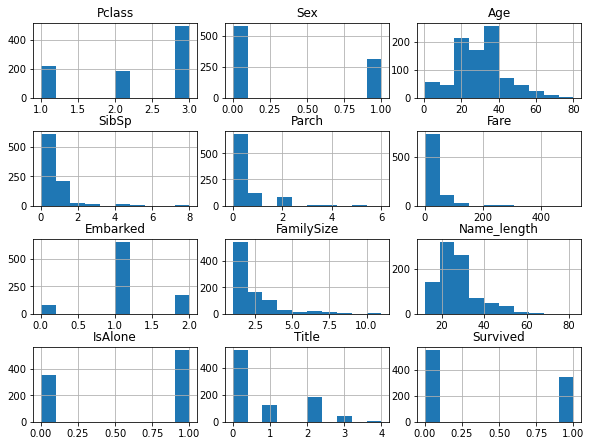

In [25]:
# Histogram
pd.concat([df.loc[traindex, :], Survived], axis=1).hist()
plt.tight_layout(pad=0)
plt.show()

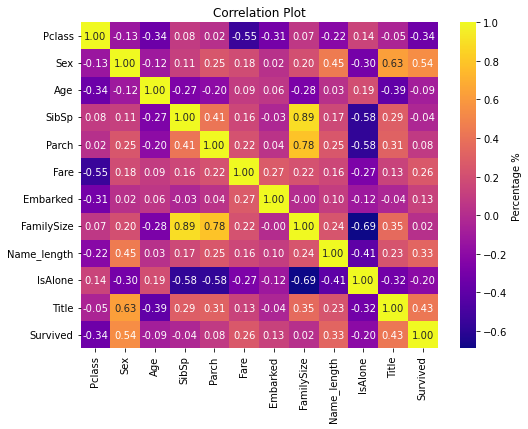

In [26]:
# Correlation Plot
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(pd.concat([df.loc[traindex, :], Survived], axis=1).corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},cmap="plasma",ax=ax)
ax.set_title("Correlation Plot")
plt.show()

In [27]:
# Scaling between -1 and 1. Good practice for continuous variables.
from sklearn import preprocessing
continuous_features = ['Fare','Age','Name_length']
for col in continuous_features:
    transf = df[col].values.reshape(-1,1)
    scaler = preprocessing.StandardScaler().fit(transf)
    df[col] = scaler.transform(transf)

# Finish Pre-Processing
# Dummmy Variables (One Hot Encoding)
#df = pd.get_dummies(df, columns=['Embarked','Title','Parch','SibSp','Pclass'], )

# Now that pre-processing is complete, split data into train/test again.
train_df = df.loc[traindex, :]
train_df['Survived'] = Survived
test_df = df.loc[testdex, :]

# Dead Weight
del df

In [28]:
# Depedent and Indepedent Variables
X = train_df.drop(["Survived"] , axis=1)
y = train_df["Survived"]
print("X, Y, Test Shape:",X.shape, y.shape, test_df.shape) # Data Dimensions

# Storage for Model and Results
results = pd.DataFrame(columns=['Model','Para','Test_Score','CV Mean','CV STDEV'])
ensemble_models= {}

X, Y, Test Shape: (891, 11) (891,) (418, 11)


In [29]:
#Imbalanced Dependent Variable
print("Depedent Variable Distribution")
print(y.value_counts(normalize=True)*100)
print("0 = Died", "\n1 = Survived")

Depedent Variable Distribution
0    61.616162
1    38.383838
Name: Survived, dtype: float64
0 = Died 
1 = Survived


In [30]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize=True)[0]/y.value_counts(normalize=True)[1]
print("Imbalance Weight: ",imbalance_weight)

Imbalance Weight:  1.605263157894737


In [31]:
#Understanding Feature Importance
#Dimensionality Reduction: Principal Components
print("Feature Count (With One Hot Encoding):", X.shape[1])

Feature Count (With One Hot Encoding): 11


In [32]:
levels = [2,4,6,8,10,12]
for x in levels:
    pca = PCA(n_components=x)
    fit = pca.fit(train_df)

    print(("{} Components \nExplained Variance: {}\n").format(x, fit.explained_variance_ratio_))
    #print(fit.components_)

2 Components 
Explained Variance: [0.45118983 0.15874474]

4 Components 
Explained Variance: [0.45118983 0.15874474 0.12176714 0.08256849]

6 Components 
Explained Variance: [0.45118983 0.15874474 0.12176714 0.08256849 0.05365997 0.04790129]

8 Components 
Explained Variance: [0.45118983 0.15874474 0.12176714 0.08256849 0.05365997 0.04790129
 0.02951155 0.02154033]

10 Components 
Explained Variance: [0.45118983 0.15874474 0.12176714 0.08256849 0.05365997 0.04790129
 0.02951155 0.02154033 0.01540524 0.00968405]

12 Components 
Explained Variance: [4.51189827e-01 1.58744743e-01 1.21767143e-01 8.25684936e-02
 5.36599696e-02 4.79012925e-02 2.95115511e-02 2.15403319e-02
 1.54052385e-02 9.68405467e-03 8.02735490e-03 4.85025441e-33]



In [33]:
"""
# Reduce Dimensionality
pca = PCA(n_components=5)
fit = pca.fit(X)

sns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Survived],
                      axis=1).corr(), annot=True, fmt=".2f")
# Apply Reduction
X = pd.DataFrame(fit.transform(X))
test_df = pd.DataFrame(fit.transform(test_df))

No longer applied to dataset since performance did not get substancially improved.
Better just use method at an individual basis, through the pipeline method.
"""

'\n# Reduce Dimensionality\npca = PCA(n_components=5)\nfit = pca.fit(X)\n\nsns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Survived],\n                      axis=1).corr(), annot=True, fmt=".2f")\n# Apply Reduction\nX = pd.DataFrame(fit.transform(X))\ntest_df = pd.DataFrame(fit.transform(test_df))\n\nNo longer applied to dataset since performance did not get substancially improved.\nBetter just use method at an individual basis, through the pipeline method.\n'

In [ ]:
#Train/Test Split

In [34]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testset_size, stratify=y,random_state=rstate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rstate)

In [ ]:
#Gradient Boosting Classifier

In [35]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [37]:
# Compute, Print, and Save Model Evaluation
def save(model, modelname):
    """
    This funciton saves the cross-validation and held-out (Test Set) accuracy scores aswell as their standard deviations
    to the "results" dataframe, then it executes the model prediction on the submission set.
    Finally, it also outputs a confusion matrix of the test set.
    
    Function Arguments:
    model = The Sklearn Randomized/Grid SearchCV model.
    modelname = String of the model name for saving purposes.
    """
    global results
    # Once best model is found, establish more evaluation metrics.
    model.best_estimator_.fit(X_train, y_train)
    scores = cross_val_score(model.best_estimator_, X_train, y_train, cv=5,
                             scoring=scoring, verbose =0)
    CV_scores = scores.mean()
    STDev = scores.std()
    Test_scores = model.score(X_test, y_test)

    # CV and Save scores
    results = results.append({'Model': modelname,'Para': model.best_params_,'Test_Score': Test_scores,
                             'CV Mean':CV_scores, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model.best_estimator_
    
    # Print Evaluation
    print("\nEvaluation Method: {}".format(scoring))
    print("Optimal Model Parameters: {}".format(grid.best_params_))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_scores, STDev, modelname))
    print('Test_Score:', Test_scores)
        
    # Scikit Confusion Matrix
    model.best_estimator_.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    # Colors https://matplotlib.org/examples/color/colormaps_reference.html

def norm_save(model,score, modelname):
    global results
    model.fit(X, y)
    submission = model.predict(test_df)
    df = pd.DataFrame({'PassengerId':test_df.index, 
                           'Survived':submission})
    
    CV_Score = score.mean()
    Test_scores = model.score(X_test, y_test)
    STDev = score.std()
    
    # CV and Save Scores
    Test_Score = model.score(X_test, y_test)
    results = results.append({'Model': modelname,'Para': model,'Test_Score': Test_scores,
                             'CV Mean': CV_Score, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model
    
    print("\nEvaluation Method: {}".format(scoring))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_Score, STDev, modelname))  
    print('Test_Score:', Test_scores)
        
    #Scikit Confusion Matrix
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    
# ROC Curve Plot
# http://scikit-plot.readthedocs.io/en/stable/metrics.html
def eval_plot(model):
    skplt.metrics.plot_roc_curve(y_test, model.predict_proba(X_test))
    plt.show()

In [38]:
param_grid ={'n_estimators': n_tree_range,
            'loss': ['deviance', 'exponential'],
            'learning_rate': [0.1, 0.01,0.05,0.001],
            'max_depth': np.arange(2, 12, 1)}

grid = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_grid,cv=cv,
                    scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Gradient_Boosting")

Fitting 2 folds for each of 70 candidates, totalling 140 fits

Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 456}
Train CV Accuracy: 0.82 (+/- 0.03) [Gradient_Boosting]
Test_Score: 0.7948717948717948


NameError: name 'skplt' is not defined